In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [6]:
import numpy as np
images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


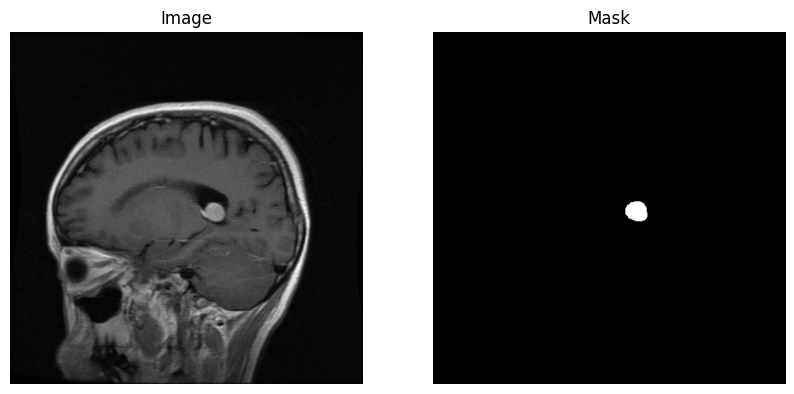

In [7]:
import matplotlib.pyplot as plt
def display_sample(data, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(data['images'][index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data['masks'][index], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# Display a sample to verify
display_sample({'images': images, 'masks': masks}, index=0)

In [8]:
from skimage.transform import resize
def preprocess_images(images, masks, target_shape=(256, 256)):
    processed_images = np.array([resize(img, target_shape, preserve_range=True) for img in images])
    processed_masks = np.array([resize(mask, target_shape, mode='constant', anti_aliasing=False) for mask in masks])

    # Normalize images
    processed_images = processed_images.astype('float32') / 255.0

    return processed_images, processed_masks

images_processed, masks_processed = preprocess_images(images, masks)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_processed, masks_processed, test_size=0.2, random_state=42)

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def segnet_model(input_size=(256, 256, 1)):
    # Encoder
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the SegNet model
model = segnet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 256)       2951

In [27]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=20)



Epoch 1/20
307/307 [==============================] - 78s 212ms/step - loss: 0.2610 - accuracy: 0.9826 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 2/20
307/307 [==============================] - 58s 189ms/step - loss: 0.2608 - accuracy: 0.9831 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 3/20
307/307 [==============================] - 58s 191ms/step - loss: 0.2608 - accuracy: 0.9831 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 4/20
307/307 [==============================] - 60s 194ms/step - loss: 0.2608 - accuracy: 0.9831 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 5/20
307/307 [==============================] - 59s 194ms/step - loss: 0.2608 - accuracy: 0.9831 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 6/20
307/307 [==============================] - 60s 195ms/step - loss: 0.2608 - accuracy: 0.9831 - val_loss: 0.2605 - val_accuracy: 0.9831
Epoch 7/20
307/307 [==============================] - 60s 195ms/step - loss: 0.2608 - accuracy: 0.9831 - val_loss: 0.2605 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


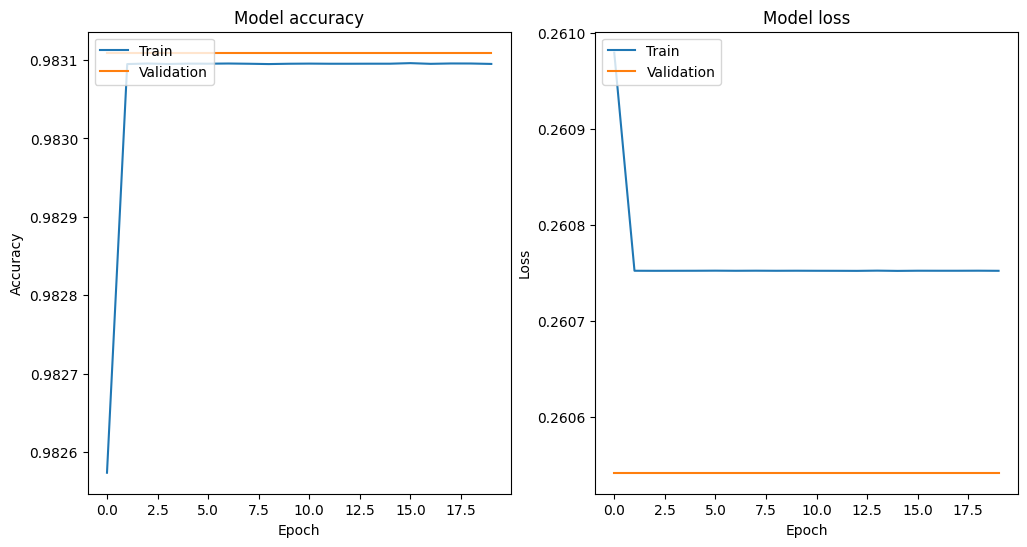

In [28]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
if 'dice_coefficient' in history.history:
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [29]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)
predictions = model.predict(X_val)

20/20 [==============================] - 14s 190ms/step - loss: 0.2605 - accuracy: 0.9831
Validation accuracy: 0.9831091165542603
20/20 [==============================] - 4s 190ms/step


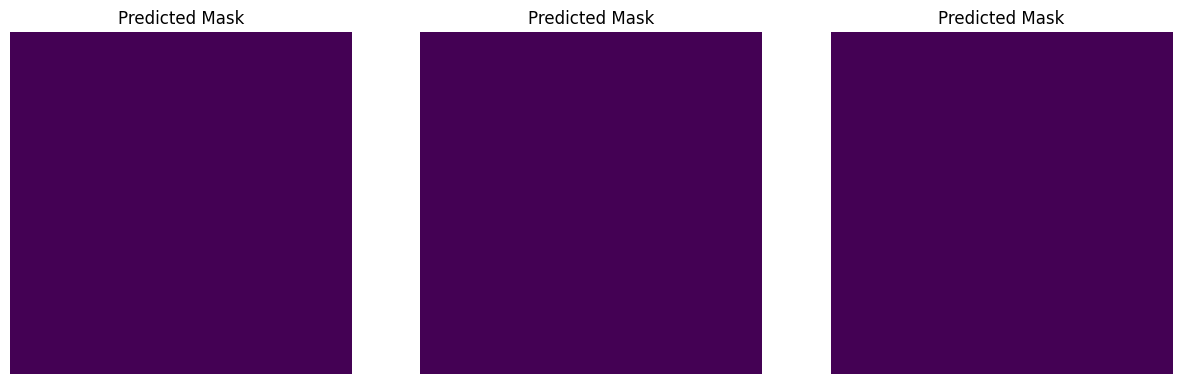

In [30]:
def display_comparison(indices):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
display_comparison([0, 1, 2])

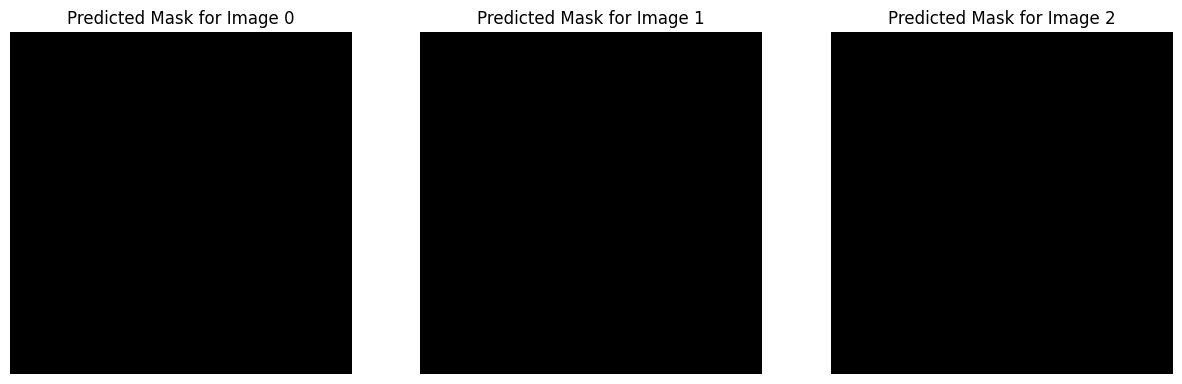

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
colors = ['black', 'red', 'green']  # Add more colors if there are more classes
cmap = ListedColormap(colors)

def display_comparison(predictions, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap=cmap)
        plt.title(f'Predicted Mask for Image {idx}')
        plt.axis('off')
    plt.show()
display_comparison(predictions, [0, 1, 2])


In [32]:
predicted_masks = model.predict(X_val)

20/20 [==============================] - 4s 189ms/step


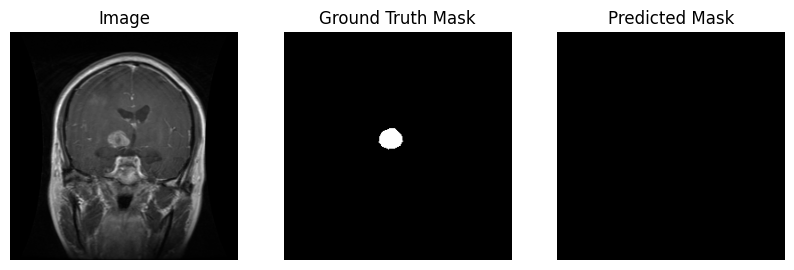

In [33]:
def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Display a sample of predicted masks on original images
display_predicted_masks(X_val, y_val, predicted_masks, index=0)

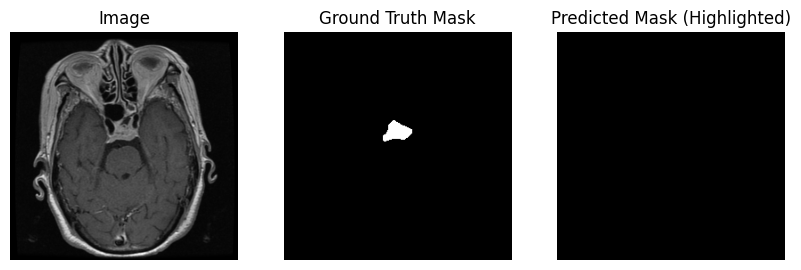

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red'])

def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap=cmap)
    plt.title('Predicted Mask (Highlighted)')
    plt.axis('off')

    plt.show()
display_predicted_masks(X_val, y_val, predicted_masks, index=150)
